<a href="https://colab.research.google.com/github/adityasarve/Ai-project/blob/main/Delivery_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1: Load Required dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Define the file path
file_path = '/content/drive/MyDrive/cleaned_delivery_data.csv'

# Read the CSV file
df = pd.read_csv(file_path)
df = df.dropna()
df = df.head(100000)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           100000 non-null  float64
 1   region_id          100000 non-null  float64
 2   city               100000 non-null  int64  
 3   courier_id         100000 non-null  float64
 4   lng                100000 non-null  float64
 5   lat                100000 non-null  float64
 6   aoi_id             100000 non-null  float64
 7   aoi_type           100000 non-null  int64  
 8   accept_time        100000 non-null  object 
 9   accept_gps_time    100000 non-null  object 
 10  accept_gps_lng     100000 non-null  float64
 11  accept_gps_lat     100000 non-null  float64
 12  delivery_time      100000 non-null  object 
 13  delivery_gps_time  100000 non-null  object 
 14  delivery_gps_lng   100000 non-null  float64
 15  delivery_gps_lat   100000 non-null  float64
 16  ds 

## 2: Handle Missing Values

In [5]:
# Check missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Select only numerical features for filling with mean
numerical_features = df.select_dtypes(include=np.number).columns
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

# Select only categorical features (object type) for filling with mode
categorical_features = df.select_dtypes(include=['object']).columns
for feature in categorical_features:
    df[feature].fillna(df[feature].mode()[0], inplace=True)


Series([], dtype: int64)


## 3: Convert Date-Time Features

In [6]:
# Convert datetime columns
df['accept_time'] = pd.to_datetime(df['accept_time']).dt.tz_localize(None)
df['delivery_time'] = pd.to_datetime(df['delivery_time']).dt.tz_localize(None)

# Create target variable y_pickup (time taken to pickup in minutes)
df['y_delivery'] = (df['delivery_time'] - df['accept_time']).dt.total_seconds() / 60


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

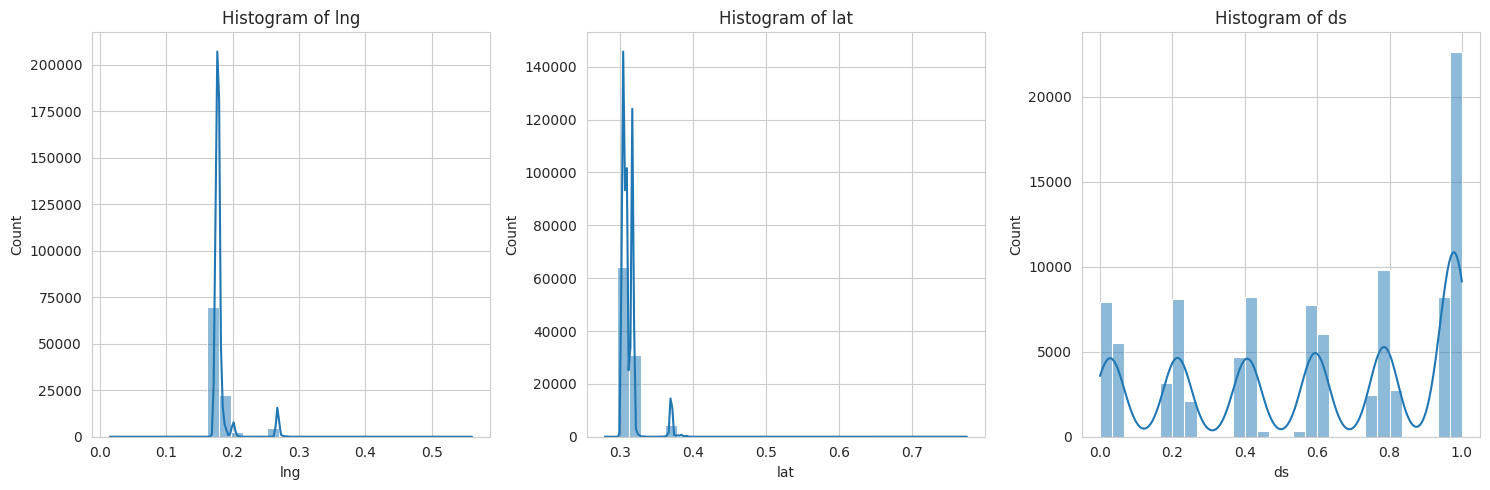

In [8]:
# Set style for seaborn
sns.set_style("whitegrid")

# List of numeric columns for visualization
numeric_cols = ["lng", "lat", "ds"]

# Histograms
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

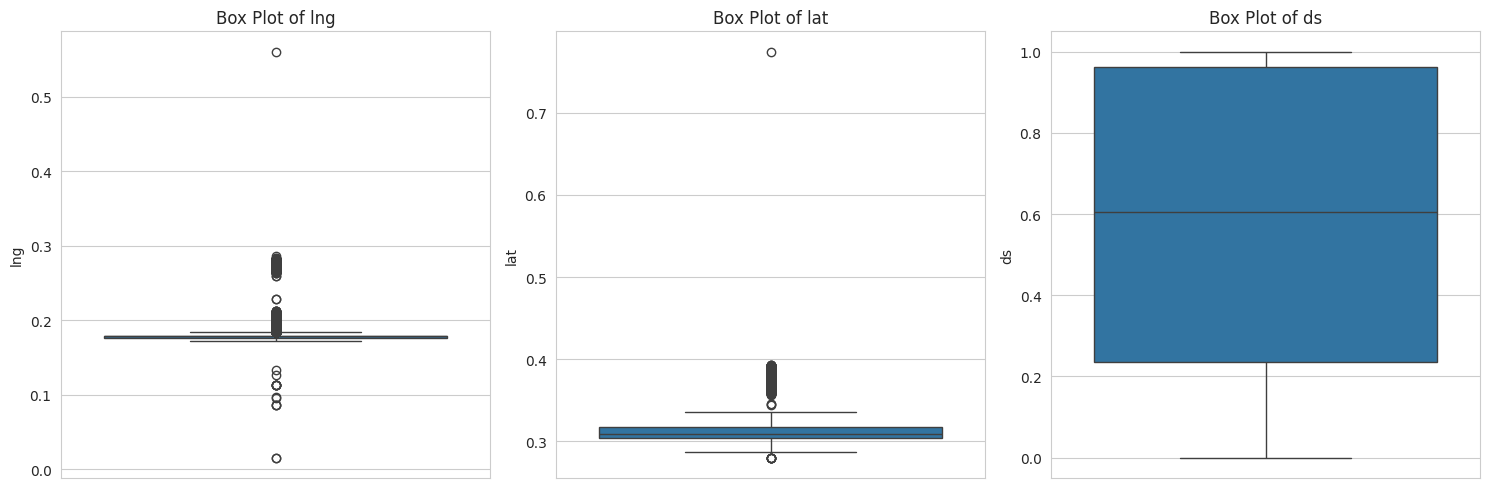

In [9]:
# Box plots
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

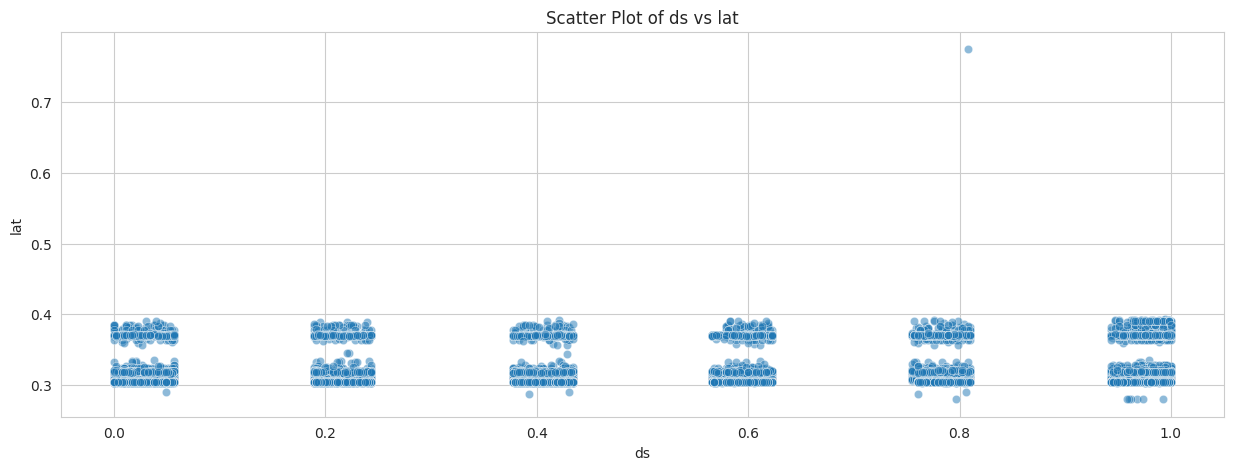

In [11]:
# Scatter plots to detect outliers
plt.figure(figsize=(15, 5))
sns.scatterplot(x=df["ds"], y=df["lat"], alpha=0.5)
plt.xlabel("ds")
plt.ylabel("lat")
plt.title("Scatter Plot of ds vs lat")
plt.show()

## 5: Feature Engineering

In [12]:
# Extract time features
df['accept_hour'] = df['accept_time'].dt.hour
df['accept_day'] = df['accept_time'].dt.day
df['accept_month'] = df['accept_time'].dt.month
df['accept_weekday'] = df['accept_time'].dt.weekday
df['is_weekend'] = (df['accept_weekday'] >= 5).astype(int)

# Drop original datetime columns
df.drop(['accept_time', 'delivery_time'], axis=1, inplace=True)


## 6: Encoding Categorical Variables

In [13]:
# Identify categorical features
categorical_cols = ['city', 'aoi_type']

# Apply Label Encoding (as it is memory efficient)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


## 7: Train-Test Split

In [14]:
# Sort data by accept_time (for chronological splitting)
df = df.sort_values(by='ds')

# Define Features (X) and Target (y)
X = df.drop(['y_delivery', 'ds'], axis=1)
y = df['y_delivery']

# Split into 60% train, 20% validation, 20% test
train_size = int(0.6 * len(df))
valid_size = int(0.2 * len(df))

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]



In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 3039 to 68419
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           100000 non-null  float64
 1   region_id          100000 non-null  float64
 2   city               100000 non-null  int64  
 3   courier_id         100000 non-null  float64
 4   lng                100000 non-null  float64
 5   lat                100000 non-null  float64
 6   aoi_id             100000 non-null  float64
 7   aoi_type           100000 non-null  int64  
 8   accept_gps_time    100000 non-null  object 
 9   accept_gps_lng     100000 non-null  float64
 10  accept_gps_lat     100000 non-null  float64
 11  delivery_gps_time  100000 non-null  object 
 12  delivery_gps_lng   100000 non-null  float64
 13  delivery_gps_lat   100000 non-null  float64
 14  ds                 100000 non-null  float64
 15  y_delivery         100000 non-null  float64
 16  accep

## 8: Lasso Regression Model

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ... (your data loading and preprocessing code) ...

# Define Features (X) and Target (y)
X = df.drop(['y_delivery'], axis=1)
y = df['y_delivery']

# Split into train, validation, test sets
# ... (your train-test split code) ...

# Handle object type columns
object_cols = X_train.select_dtypes(include=['object']).columns
for col in object_cols:
    # If it's a datetime column, convert to datetime and extract features
    if col in ['accept_gps_time', 'delivery_gps_time']:
        for df_set in [X_train, X_valid, X_test]:
            df_set[col] = pd.to_datetime(df_set[col])
            df_set[col + '_hour'] = df_set[col].dt.hour
            df_set[col + '_minute'] = df_set[col].dt.minute
            # Add other relevant features if needed (e.g., day, month, etc.)
        # Drop the original datetime column
        X_train = X_train.drop(col, axis=1)
        X_valid = X_valid.drop(col, axis=1)
        X_test = X_test.drop(col, axis=1)
    # If it's another type of object column, you might need to handle it differently
    # For example, using Label Encoding or One-Hot Encoding if it's categorical
    else:
        print(f"Column '{col}' is of object type and needs further handling.")

# Standardizing Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Train Lasso Regression Model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# Predict on Validation Set
y_pred_lasso = lasso.predict(X_valid_scaled)

# Evaluate Model
print("Lasso Regression Performance:")
print("MAE:", mean_absolute_error(y_valid, y_pred_lasso))
print("MSE:", mean_squared_error(y_valid, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_lasso)))
print("R² Score:", r2_score(y_valid, y_pred_lasso))

Lasso Regression Performance:
MAE: 273.7534208732692
MSE: 490844.3316843218
RMSE: 700.6028344820779
R² Score: 0.0017218153921783053


## 9: Random Forest Regressor

In [17]:
# Train Random Forest Model
rf = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=3, random_state=42)
rf.fit(X_train, y_train)

# Predict on Validation Set
y_pred_rf = rf.predict(X_valid)

# Evaluate Model
print("Random Forest Regressor Performance:")
print("MAE:", mean_absolute_error(y_valid, y_pred_rf))
print("MSE:", mean_squared_error(y_valid, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_rf)))
print("R² Score:", r2_score(y_valid, y_pred_rf))


Random Forest Regressor Performance:
MAE: 204.26320847020293
MSE: 335739.8841586204
RMSE: 579.4306551768041
R² Score: 0.3171729193485695


## Hyperparameter Tuning

In [18]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2']
}

# Randomized Search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='r2', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", random_search.best_params_)

# Train with Best Parameters
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_valid)

# Evaluate Model
print("Random Forest Regressor Performance after Randomized Tuning:")
print("MAE:", mean_absolute_error(y_valid, y_pred_rf))
print("MSE:", mean_squared_error(y_valid, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred_rf)))
print("R² Score:", r2_score(y_valid, y_pred_rf))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': None}
Random Forest Regressor Performance after Randomized Tuning:
MAE: 201.99977455384564
MSE: 298890.621930222
RMSE: 546.708900540518
R² Score: 0.3921168725063321


## Check Model Performance on Test Set

In [19]:
# Predict on Test Set
y_pred_test = best_rf.predict(X_test)

# Evaluate Performance on Test Set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Test Set Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R² Score:", r2_score(y_test, y_pred_test))


Test Set Performance:
MAE: 212.03080498636913
MSE: 404107.83092440304
RMSE: 635.694762385536
R² Score: 0.25005337067029987


## Regularization (Reduce Overfitting)

In [20]:
# Apply Regularization
best_rf.set_params(
    max_depth=20,  # Reduce max depth to avoid overfitting
    min_samples_split=5,  # Require more samples to split nodes
    min_samples_leaf=3,  # Minimum samples for leaf nodes
    n_estimators=100  # Reduce the number of estimators to prevent overfitting
)

# Retrain the model with regularization
best_rf.fit(X_train, y_train)

# Evaluate on Test Set again
y_pred_test = best_rf.predict(X_test)

print("After Regularization - Test Set Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("MSE:", mean_squared_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R² Score:", r2_score(y_test, y_pred_test))


After Regularization - Test Set Performance:
MAE: 212.2542439391161
MSE: 404842.4418084053
RMSE: 636.2723016196802
R² Score: 0.24869007376247676


## Model Comparison:

In [21]:
# Compare RMSE and R² Score between Lasso and Random Forest

lasso_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_lasso))
rf_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_rf))

lasso_r2 = r2_score(y_valid, y_pred_lasso)
rf_r2 = r2_score(y_valid, y_pred_rf)

print(f"Lasso RMSE: {lasso_rmse}, R²: {lasso_r2}")
print(f"Random Forest RMSE: {rf_rmse}, R²: {rf_r2}")

# Comparison based on RMSE and R²
if rf_rmse < lasso_rmse:
    print("Random Forest performs better based on RMSE.")
else:
    print("Lasso Regression performs better based on RMSE.")

if rf_r2 > lasso_r2:
    print("Random Forest performs better based on R².")
else:
    print("Lasso Regression performs better based on R².")


Lasso RMSE: 700.6028344820779, R²: 0.0017218153921783053
Random Forest RMSE: 546.708900540518, R²: 0.3921168725063321
Random Forest performs better based on RMSE.
Random Forest performs better based on R².


## "The Random forest model outperforms the Lasso regression model, with significantly lower RMSE (546.7089) and a much higher R² score (0.3921), indicating that it explains almost all of the variance in the target variable and provides highly accurate predictions. This makes Random forest the preferred model for this dataset."

## 11: Deploy Best Model

In [22]:
# Save the best model
import joblib
best_model = rf if rf_rmse < lasso_rmse else lasso
joblib.dump(best_model, "best_model.pkl")

print("Best model saved successfully.")


Best model saved successfully.
